# Urban Gaps
In this notebook, we examine the average urban-level gaps across our continuous features and targets between those in the lowest and highest median income quartiles. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
import statsmodels.api as sm
from lxml import etree

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Data

In [2]:
data = pd.read_csv('data/data.csv', low_memory=False)

In [3]:
urban_df = pd.read_csv('data/Census_UHI_US_Urbanized_climzone_metadata.csv')

In [4]:
variables = ['CUHI Day', 'CUHI Night', 'SUHI Day', 'SUHI Night', 
             'Built Fraction', 'Grass Fraction', 'Tree Fraction', 'Elevation', 
             'Albedo', 'Built Albedo', 'Grass Albedo', 'Tree Albedo']

In [362]:
med25

'Median Income (25th percentile)'

In [361]:
data[data[med25+'?']==True][med25+'?'].value_counts()[0]

14021

In [363]:
data[data[med75+'?']==True][med75+'?'].value_counts()[0]

14024

## Urban Disparity Panel

### Disparity Calculations
Calculate the mean variable difference between the 25th and 75th percentile median income by urban area.

In [10]:
def weighted_average(group, x):
    return np.average(group[x], weights=group['Area'])

cols  = ['CUHI Day', 'CUHI Night', 'SUHI Day', 'SUHI Night', 
         'Built Fraction', 'Grass Fraction', 'Tree Fraction', 'Elevation', 
         'Albedo', 'Built Albedo', 'Grass Albedo', 'Tree Albedo']

med25 = 'Median Income (25th percentile)'
med75 = 'Median Income (75th percentile)'
# Calculate the 25th and 75th percentile of median income by urban area
grouped25 = pd.DataFrame({med25: data.groupby(['Urban_name'])['Median Income'].quantile(0.25)}).reset_index()
grouped75 = pd.DataFrame({med75: data.groupby(['Urban_name'])['Median Income'].quantile(0.75)}).reset_index()
# Add a column for the 25th and 75th percentile of median income by urban area
data = data.merge(grouped25, on='Urban_name')
data = data.merge(grouped75, on='Urban_name')
# Compare tract median income with urban area 25th and 75th percentile median income
data[med25 + '?'] = data['Median Income'] <= data[med25]
data[med75 + '?'] = data['Median Income'] >= data[med75]
#display(data.head())

result = urban_df.copy().reset_index().drop(columns='index')
for i in range(len(cols)):    
    #xprint(cols[i])
    # Filter data points at or below Q1 and Q3, and then calculate the median predicted UHI by urban area
    col25 = cols[i] + ' (25th %tile)'
    col75 = cols[i] + ' (75th %tile)'
    m25 = pd.DataFrame({col25: data[data[med25 + '?'] == True][['Urban_name', cols[i], 'Area']].dropna().groupby(['Urban_name']).apply(lambda group: weighted_average(group, x=cols[i]))}).reset_index()  
    m75 = pd.DataFrame({col75: data[data[med75 + '?'] == True][['Urban_name', cols[i], 'Area']].dropna().groupby(['Urban_name']).apply(lambda group: weighted_average(group, x=cols[i]))}).reset_index()
    # Update the results
    result = result.merge(m25, on='Urban_name')
    result = result.merge(m75, on='Urban_name')
    result[cols[i] + ' (Difference)'] = result[col75] - result[col25]

In [11]:
centroids = pd.read_csv('data/Centroids_USUHI.csv', usecols=['Lat','Lon','Urban_name'])
result = result.merge(centroids, on='Urban_name')

area_df = pd.read_csv('data/Census_UHI_US_Urbanized_vegetation_albedo_CUHI_SUHI_area.csv')
area_df = area_df[['Urban_name', 'Area_all']].drop_duplicates()
result = result.merge(area_df, on='Urban_name')

display(result.head())

system:index  Clim_zone  Coastal?                Urban_name  \
0  00000000000000000000       Arid     False        Denver--Aurora, CO   
1  00000000000000000001       Snow     False            Des Moines, IA   
2  00000000000000000002       Snow     False               Detroit, MI   
3  00000000000000000003  Temperate     False                Dothan, AL   
4  00000000000000000004       Snow     False  Dover--Rochester, NH--ME   

                                                .geo  CUHI Day (25th %tile)  \
0  {"type":"Point","coordinates":[-104.9116864828...               0.742087   
1  {"type":"Point","coordinates":[-93.64925307140...               0.115801   
2  {"type":"Point","coordinates":[-83.21850259851...               0.614821   
3  {"type":"Point","coordinates":[-85.43345475538...              -0.147149   
4  {"type":"Point","coordinates":[-70.91964071905...              -0.463352   

   CUHI Day (75th %tile)  CUHI Day (Difference)  CUHI Night (25th %tile)  \
0              -1.596664              -2.338750                 0.786631   
1              -0.299990              -0.415791                 0.340558   
2              -0.198969              -0.813790                 0.581902   
3              -0.162720              -0.015571                -0.180046   
4              -0.090947               0.372406                -0.449514   

   CUHI Night (75th %tile)  CUHI Night (Difference)  SUHI Day (25th %tile)  \
0                -1.168397                -1.955027               2.183896   
1                -0.345549                -0.686107               0.703543   
2                -0.176749                -0.758651               4.569026   
3                -0.177395                 0.002651              -1.682099   
4                 0.093960                 0.543473              -1.239916   

   SUHI Day (75th %tile)  SUHI Day (Difference)  SUHI Night (25th %tile)  \
0              -3.088958              -5.272854                 1.424926   
1              -2.437533              -3.141076                 1.007478   
2              -1.189764              -5.758790                 1.450190   
3              -2.161296              -0.479197                -0.533405   
4              -1.325818              -0.085902                -0.274796   

   SUHI Night (75th %tile)  SUHI Night (Difference)  \
0                -1.546296                -2.971222   
1                -1.087753                -2.095232   
2                -0.239587                -1.689778   
3                -0.658425                -0.125020   
4                 0.136488                 0.411285   

   Built Fraction (25th %tile)  Built Fraction (75th %tile)  \
0                     0.367848                    -0.099424   
1                     0.077959                    -0.111911   
2                     0.321663                     0.021244   
3                    -0.032699                    -0.059923   
4                    -0.003331                    -0.014112   

   Built Fraction (Difference)  Grass Fraction (25th %tile)  \
0                    -0.467271                    -0.359862   
1                    -0.189870                    -0.151759   
2                    -0.300419                    -0.079951   
3                    -0.027224                     0.018579   
4                    -0.010781                    -0.057504   

   Grass Fraction (75th %tile)  Grass Fraction (Difference)  \
0                     0.038694                     0.398556   
1                    -0.167915                    -0.016155   
2                    -0.059632                     0.020319   
3                     0.066729                     0.048150   
4                    -0.028572                     0.028932   

   Tree Fraction (25th %tile)  Tree Fraction (75th %tile)  \
0                   -0.017037                    0.151363   
1                    0.130900                   -0.145906   
2                   -0.248740                   -0.050735

In [9]:
result[[var + ' (Difference)' for var in variables]].describe().round(3)

CUHI Day (Difference)  CUHI Night (Difference)  SUHI Day (Difference)  \
count                493.000                  493.000                493.000   
mean                  -0.490                   -0.371                 -2.356   
std                    0.981                    0.677                  2.647   
min                   -6.236                   -4.118                -12.824   
25%                   -0.601                   -0.601                 -4.014   
50%                   -0.293                   -0.299                 -2.169   
75%                   -0.081                   -0.065                 -0.610   
max                    2.731                    2.429                  6.313   

       SUHI Night (Difference)  Built Fraction (Difference)  \
count                  493.000                      493.000   
mean                    -0.695                       -0.171   
std                      0.990                        0.168   
min                     -4.257                       -0.750   
25%                     -1.383                       -0.274   
50%                     -0.705                       -0.150   
75%                     -0.074                       -0.038   
max                      2.988                        0.322   

       Grass Fraction (Difference)  Tree Fraction (Difference)  \
count                      493.000                     493.000   
mean                         0.049                       0.060   
std                          0.142                       0.178   
min                         -0.323                      -0.575   
25%                         -0.028                      -0.038   
50%                          0.020                       0.046   
75%                          0.095                       0.143   
max                          0.731                       0.689   

       Elevation (Difference)  Albedo (Difference)  Built Albedo (Difference)  \
count                 493.000              493.000                    493.000   
mean                   47.908               -0.003                     -0.002   
std                   126.096                0.018                      0.015   
min                  -396.804               -0.078                     -0.048   
25%                    -1.154               -0.012                     -0.012   
50%                    15.134               -0.002                     -0.001   
75%                    51.108                0.006                      0.008   
max                   728.659                0.060                      0.049   

       Grass Albedo (Difference)  Tree Albedo (Difference)  
count                    493.000                   493.000  
mean                      -0.001                    -0.002  
std                        0.012                     0.011  
min                       -0.049                    -0.081  
25%                       -0.006                    -0.007  
50%                       -0.000                    -0.001  
75%                        0.005                     0.004  
max                        0.101                     0.034

In [10]:
result[[var + ' (25th %tile)' for var in variables]].describe().round(3)

CUHI Day (25th %tile)  CUHI Night (25th %tile)  SUHI Day (25th %tile)  \
count                493.000                  493.000                493.000   
mean                   0.103                    0.136                  0.803   
std                    0.498                    0.431                  2.105   
min                   -2.855                   -1.887                 -7.253   
25%                   -0.039                   -0.040                 -0.566   
50%                    0.122                    0.155                  0.781   
75%                    0.287                    0.338                  2.083   
max                    2.893                    1.813                  7.326   

       SUHI Night (25th %tile)  Built Fraction (25th %tile)  \
count                  493.000                      493.000   
mean                     0.358                        0.126   
std                      0.729                        0.163   
min                     -2.553                       -0.327   
25%                     -0.121                        0.005   
50%                      0.380                        0.102   
75%                      0.857                        0.225   
max                      2.261                        0.776   

       Grass Fraction (25th %tile)  Tree Fraction (25th %tile)  \
count                      493.000                     493.000   
mean                        -0.078                      -0.089   
std                          0.114                       0.145   
min                         -0.626                      -0.707   
25%                         -0.136                      -0.168   
50%                         -0.069                      -0.075   
75%                         -0.019                      -0.003   
max                          0.527                       0.477   

       Elevation (25th %tile)  Albedo (25th %tile)  Built Albedo (25th %tile)  \
count                 493.000              493.000                    493.000   
mean                   -3.253               -0.004                      0.002   
std                    50.827                0.015                      0.013   
min                  -208.241               -0.078                     -0.059   
25%                   -20.085               -0.010                     -0.006   
50%                    -6.107               -0.003                      0.003   
75%                     1.254                0.004                      0.010   
max                   312.140                0.065                      0.054   

       Grass Albedo (25th %tile)  Tree Albedo (25th %tile)  
count                    493.000                   493.000  
mean                      -0.001                    -0.001  
std                        0.010                     0.010  
min                       -0.106                    -0.048  
25%                       -0.005                    -0.006  
50%                       -0.002                    -0.002  
75%                        0.002                     0.003  
max                        0.055                     0.073

In [11]:
result[[var + ' (75th %tile)' for var in variables]].describe().round(3)

CUHI Day (75th %tile)  CUHI Night (75th %tile)  SUHI Day (75th %tile)  \
count                493.000                  493.000                493.000   
mean                  -0.387                   -0.235                 -1.552   
std                    0.810                    0.492                  1.644   
min                   -5.441                   -3.739                 -9.398   
25%                   -0.345                   -0.322                 -2.203   
50%                   -0.166                   -0.164                 -1.424   
75%                   -0.079                   -0.038                 -0.760   
max                    1.933                    1.570                  4.922   

       SUHI Night (75th %tile)  Built Fraction (75th %tile)  \
count                  493.000                      493.000   
mean                    -0.337                       -0.045   
std                      0.617                        0.081   
min                     -3.687                       -0.355   
25%                     -0.648                       -0.083   
50%                     -0.328                       -0.038   
75%                     -0.036                       -0.010   
max                      1.949                        0.561   

       Grass Fraction (75th %tile)  Tree Fraction (75th %tile)  \
count                      493.000                     493.000   
mean                        -0.029                      -0.029   
std                          0.112                       0.133   
min                         -0.381                      -0.526   
25%                         -0.089                      -0.099   
50%                         -0.032                      -0.033   
75%                          0.012                       0.035   
max                          0.482                       0.630   

       Elevation (75th %tile)  Albedo (75th %tile)  Built Albedo (75th %tile)  \
count                 493.000              493.000                    493.000   
mean                   44.655               -0.007                      0.001   
std                   109.166                0.014                      0.011   
min                   -99.184               -0.064                     -0.065   
25%                    -2.284               -0.014                     -0.005   
50%                     7.594               -0.004                      0.000   
75%                    36.755                0.000                      0.006   
max                   706.568                0.094                      0.057   

       Grass Albedo (75th %tile)  Tree Albedo (75th %tile)  
count                    493.000                   493.000  
mean                      -0.003                    -0.003  
std                        0.009                     0.009  
min                       -0.048                    -0.036  
25%                       -0.006                    -0.007  
50%                       -0.001                    -0.003  
75%                        0.002                     0.001  
max                        0.041                     0.040

### Statistically Significant Disparities

In [86]:
def sig(pval):
    """Return whether the p value is significant"""
    if pval <= 0.05:
        return True
    else:
        return False

In [87]:
def set_shape(sign, slope):
    # Conditions
    if sign == 'pos':
        condition1 = slope <= 0 # Median Income and yvar negatively associated, no disparity
        condition2 = slope > 0  # Median Income and yvar positively associated
    if sign == 'neg':
        condition1 = slope >= 0 # Median Income and yvar positively associated, no disparity
        condition2 = slope < 0  # Median Income and yvar negatively associated
    # Values to assign based on conditions
    value1 = ['circle']      # association is NOT an income disparity
    value2 = ['triangle-up'] # association is an income disparity

    # Assign the symbol using np.select
    return np.select([condition1, condition2],
                     [value1, value2],
                     default='Unknown')[0]

In [88]:
def get_model(group, xvar, yvar, sign):
    series_dict = {}
    
    X = group[xvar]
    y = group[yvar]
    X       = sm.add_constant(X)
    model   = sm.OLS(y, np.asarray(X))
    results = model.fit()
    series_dict[yvar + ' Slope'] = results.params['x1']
    series_dict[yvar + ' pval']  = results.pvalues['x1']
    series_dict[yvar + ' Sig']   = sig(results.pvalues['x1'])
    series_dict[yvar + ' Shape'] = set_shape(sign, results.params['x1'])
    
    return pd.Series(series_dict)

In [89]:
xvar  = 'Median Income (K)'
yvars = ['CUHI Day', 'CUHI Night', 'SUHI Day', 'SUHI Night', 
         'Built Fraction', 'Grass Fraction', 'Tree Fraction', 'Elevation', 
         'Albedo', 'Built Albedo', 'Grass Albedo', 'Tree Albedo']
signs = ['neg', 'neg', 'neg', 'neg', 'neg', 'pos', 'pos', 'pos', 'neg', 'neg', 'neg', 'neg']
idx = 0
for yvar in yvars:
    stat_diff = data[[xvar, 
                      yvar, 
                      'Urban_name']].dropna().groupby(['Urban_name']).apply(lambda group: get_model(group,
                                                                                                    xvar=xvar, 
                                                                                                    yvar=yvar, 
                                                                                                    sign=signs[idx]))
    result = result.merge(stat_diff, on='Urban_name')
    idx+=1

In [90]:
result.head()

system:index  Clim_zone  Coastal?                Urban_name  \
0  00000000000000000000       Arid     False        Denver--Aurora, CO   
1  00000000000000000001       Snow     False            Des Moines, IA   
2  00000000000000000002       Snow     False               Detroit, MI   
3  00000000000000000003  Temperate     False                Dothan, AL   
4  00000000000000000004       Snow     False  Dover--Rochester, NH--ME   

                                                .geo  CUHI Day (25th %tile)  \
0  {"type":"Point","coordinates":[-104.9116864828...               0.742087   
1  {"type":"Point","coordinates":[-93.64925307140...               0.115801   
2  {"type":"Point","coordinates":[-83.21850259851...               0.614821   
3  {"type":"Point","coordinates":[-85.43345475538...              -0.147149   
4  {"type":"Point","coordinates":[-70.91964071905...              -0.463352   

   CUHI Day (75th %tile)  CUHI Day (Difference)  CUHI Night (25th %tile)  \
0              -1.596664              -2.338750                 0.786631   
1              -0.299990              -0.415791                 0.340558   
2              -0.198969              -0.813790                 0.581902   
3              -0.162720              -0.015571                -0.180046   
4              -0.090947               0.372406                -0.449514   

   CUHI Night (75th %tile)  CUHI Night (Difference)  SUHI Day (25th %tile)  \
0                -1.168397                -1.955027               2.183896   
1                -0.345549                -0.686107               0.703543   
2                -0.176749                -0.758651               4.569026   
3                -0.177395                 0.002651              -1.682099   
4                 0.093960                 0.543473              -1.239916   

   SUHI Day (75th %tile)  SUHI Day (Difference)  SUHI Night (25th %tile)  \
0              -3.088958              -5.272854                 1.424926   
1              -2.437533              -3.141076                 1.007478   
2              -1.189764              -5.758790                 1.450190   
3              -2.161296              -0.479197                -0.533405   
4              -1.325818              -0.085902                -0.274796   

   SUHI Night (75th %tile)  SUHI Night (Difference)  \
0                -1.546296                -2.971222   
1                -1.087753                -2.095232   
2                -0.239587                -1.689778   
3                -0.658425                -0.125020   
4                 0.136488                 0.411285   

   Built Fraction (25th %tile)  Built Fraction (75th %tile)  \
0                     0.367848                    -0.099424   
1                     0.077959                    -0.111911   
2                     0.321663                     0.021244   
3                    -0.032699                    -0.059923   
4                    -0.003331                    -0.014112   

   Built Fraction (Difference)  Grass Fraction (25th %tile)  \
0                    -0.467271                    -0.359862   
1                    -0.189870                    -0.151759   
2                    -0.300419                    -0.079951   
3                    -0.027224                     0.018579   
4                    -0.010781                    -0.057504   

   Grass Fraction (75th %tile)  Grass Fraction (Difference)  \
0                     0.038694                     0.398556   
1                    -0.167915                    -0.016155   
2                    -0.059632                     0.020319   
3                     0.066729                     0.048150   
4                    -0.028572                     0.028932   

   Tree Fraction (25th %tile)  Tree Fraction (75th %tile)  \
0                   -0.017037                    0.151363   
1                    0.130900                   -0.145906   
2                   -0.248740                   -0.050735

In [17]:
cols = ['CUHI Day', 'CUHI Night', 'SUHI Day', 'SUHI Night', 
         'Built Fraction', 'Grass Fraction', 'Tree Fraction', 'Elevation', 
         'Albedo', 'Built Albedo', 'Grass Albedo', 'Tree Albedo']
for i in range(len(cols)):
    if signs[i] == 'pos':
        print(cols[i], ' Slope:', len(result[result[variables[i] + ' Slope'] > 0]))
        print(cols[i], ' pval:', len(result[(result[variables[i] + ' Slope'] > 0) & (result[variables[i] + ' pval'] < 0.05)]))
    else: 
        print(cols[i], ' Slope:', len(result[result[variables[i] + ' Slope'] < 0]))
        print(cols[i], ' pval:', len(result[(result[variables[i] + ' Slope'] < 0) & (result[variables[i] + ' pval'] < 0.05)]))
    #print(cols[i], ' pval:', len(result[result[variables[i] + ' pval'] < 0.05]))

CUHI Day  Slope: 449
CUHI Day  pval: 304
CUHI Night  Slope: 413
CUHI Night  pval: 273
SUHI Day  Slope: 459
SUHI Day  pval: 309
SUHI Night  Slope: 408
SUHI Night  pval: 261
Built Fraction  Slope: 470
Built Fraction  pval: 369
Grass Fraction  Slope: 349
Grass Fraction  pval: 154
Tree Fraction  Slope: 361
Tree Fraction  pval: 201
Elevation  Slope: 368
Elevation  pval: 199
Albedo  Slope: 325
Albedo  pval: 155
Built Albedo  Slope: 279
Built Albedo  pval: 99
Grass Albedo  Slope: 238
Grass Albedo  pval: 70
Tree Albedo  Slope: 287
Tree Albedo  pval: 115


In [18]:
len(result[result['Albedo Slope'] < 0]), len(result[(result['Albedo Slope'] < 0) & (result['Albedo pval'] < 0.05)])

(325, 155)

In [19]:
len(result[result['Albedo (Difference)'] < 0])

278

In [348]:
round((278/493),2)

0.56

In [20]:
result[result['Albedo (Difference)'] > 0]['Albedo (Difference)'].mean().round(2)

0.01

In [21]:
round((325/493),2)

0.66

In [22]:
round((len(result[result['Tree Fraction (Difference)'] > 0]) / 493), 2)

0.62

In [23]:
result[result['Tree Fraction (Difference)'] > 0]['Tree Fraction (Difference)'].mean().round(2)

0.16

In [24]:
result[result['Tree Fraction (Difference)'] < 0]['Tree Fraction (Difference)'].mean().round(2)

-0.1

In [25]:
len(result[result['CUHI Day (Difference)'] < 0])

406

In [26]:
len(result[result['CUHI Day (Difference)'] > 0])

87

In [344]:
68/41

1.6585365853658536

In [27]:
result[result['CUHI Day (Difference)'] > 0]['CUHI Day (Difference)'].describe().round(2)

count    87.00
mean      0.41
std       0.52
min       0.00
25%       0.08
50%       0.22
75%       0.51
max       2.73
Name: CUHI Day (Difference), dtype: float64

In [28]:
result[result['CUHI Day (Difference)'] < 0]['CUHI Day (Difference)'].describe().round(2)

count    406.00
mean      -0.68
std        0.95
min       -6.24
25%       -0.71
50%       -0.38
75%       -0.20
max       -0.00
Name: CUHI Day (Difference), dtype: float64

In [29]:
round((449 / 493),2)

0.91

In [347]:
data.groupby(['Climate Zone'])['Tree Fraction'].mean().round(3)

Climate Zone
Arid         0.003
Snow        -0.113
Temperate   -0.170
Tropical    -0.191
Name: Tree Fraction, dtype: float64

In [345]:
result.groupby(['Clim_zone'])[[col + ' (Difference)' for col in ['CUHI Day', 'CUHI Night', 'SUHI Day', 'SUHI Night', 
                                                     'Built Fraction', 'Grass Fraction', 'Tree Fraction', 'Elevation', 
                                                     'Albedo', 'Built Albedo', 'Grass Albedo', 'Tree Albedo']]].mean().round(2)

CUHI Day (Difference)  CUHI Night (Difference)  \
Clim_zone                                                   
Arid                       -0.65                    -0.53   
Snow                       -0.64                    -0.56   
Temperate                  -0.44                    -0.30   
Tropical                    0.39                     0.49   

           SUHI Day (Difference)  SUHI Night (Difference)  \
Clim_zone                                                   
Arid                       -1.05                    -0.69   
Snow                       -3.61                    -1.10   
Temperate                  -2.14                    -0.56   
Tropical                    1.49                     0.61   

           Built Fraction (Difference)  Grass Fraction (Difference)  \
Clim_zone                                                             
Arid                             -0.15                         0.12   
Snow                             -0.23                         0.02   
Temperate                        -0.15                         0.05   
Tropical                          0.05                         0.08   

           Tree Fraction (Difference)  Elevation (Difference)  \
Clim_zone                                                       
Arid                             0.01                   71.07   
Snow                             0.06                   57.39   
Temperate                        0.07                   45.76   
Tropical                        -0.08                  -81.92   

           Albedo (Difference)  Built Albedo (Difference)  \
Clim_zone                                                   
Arid                     -0.01                      -0.00   
Snow                      0.00                       0.00   
Temperate                -0.00                      -0.00   
Tropical                  0.00                       0.01   

           Grass Albedo (Difference)  Tree Albedo (Difference)  
Clim_zone                                                       
Arid                            -0.0                     -0.00  
Snow                             0.0                      0.00  
Temperate                       -0.0                     -0.00  
Tropical                         0.0                     -0.01

In [350]:
result.groupby(['Clim_zone'])[[col + ' (25th %tile)' for col in ['CUHI Day', 'CUHI Night', 'SUHI Day', 'SUHI Night', 
                                                     'Built Fraction', 'Grass Fraction', 'Tree Fraction', 'Elevation', 
                                                     'Albedo', 'Built Albedo', 'Grass Albedo', 'Tree Albedo']]].mean().round(2)

CUHI Day (25th %tile)  CUHI Night (25th %tile)  \
Clim_zone                                                   
Arid                       -0.07                    -0.04   
Snow                        0.20                     0.24   
Temperate                   0.11                     0.14   
Tropical                   -0.38                    -0.44   

           SUHI Day (25th %tile)  SUHI Night (25th %tile)  \
Clim_zone                                                   
Arid                        0.15                     0.05   
Snow                        1.77                     0.64   
Temperate                   0.54                     0.30   
Tropical                   -1.26                    -0.39   

           Built Fraction (25th %tile)  Grass Fraction (25th %tile)  \
Clim_zone                                                             
Arid                              0.05                        -0.05   
Snow                              0.18                        -0.09   
Temperate                         0.12                        -0.08   
Tropical                          0.01                        -0.07   

           Tree Fraction (25th %tile)  Elevation (25th %tile)  \
Clim_zone                                                       
Arid                             0.01                   15.85   
Snow                            -0.11                  -10.27   
Temperate                       -0.09                   -6.64   
Tropical                        -0.06                   84.26   

           Albedo (25th %tile)  Built Albedo (25th %tile)  \
Clim_zone                                                   
Arid                     -0.00                       0.00   
Snow                     -0.01                      -0.00   
Temperate                -0.00                       0.01   
Tropical                  0.01                       0.01   

           Grass Albedo (25th %tile)  Tree Albedo (25th %tile)  
Clim_zone                                                       
Arid                            -0.0                     -0.00  
Snow                            -0.0                     -0.00  
Temperate                       -0.0                     -0.00  
Tropical                         0.0                      0.02

In [351]:
result.groupby(['Clim_zone'])[[col + ' (75th %tile)' for col in ['CUHI Day', 'CUHI Night', 'SUHI Day', 'SUHI Night', 
                                                     'Built Fraction', 'Grass Fraction', 'Tree Fraction', 'Elevation', 
                                                     'Albedo', 'Built Albedo', 'Grass Albedo', 'Tree Albedo']]].mean().round(2)

CUHI Day (75th %tile)  CUHI Night (75th %tile)  \
Clim_zone                                                   
Arid                       -0.72                    -0.58   
Snow                       -0.44                    -0.32   
Temperate                  -0.33                    -0.16   
Tropical                    0.01                     0.05   

           SUHI Day (75th %tile)  SUHI Night (75th %tile)  \
Clim_zone                                                   
Arid                       -0.90                    -0.63   
Snow                       -1.84                    -0.46   
Temperate                  -1.59                    -0.26   
Tropical                    0.23                     0.22   

           Built Fraction (75th %tile)  Grass Fraction (75th %tile)  \
Clim_zone                                                             
Arid                             -0.10                         0.07   
Snow                             -0.05                        -0.08   
Temperate                        -0.04                        -0.02   
Tropical                          0.06                         0.00   

           Tree Fraction (75th %tile)  Elevation (75th %tile)  \
Clim_zone                                                       
Arid                             0.02                   86.93   
Snow                            -0.05                   47.12   
Temperate                       -0.02                   39.12   
Tropical                        -0.15                    2.33   

           Albedo (75th %tile)  Built Albedo (75th %tile)  \
Clim_zone                                                   
Arid                     -0.01                      -0.00   
Snow                     -0.00                       0.00   
Temperate                -0.01                       0.00   
Tropical                  0.02                       0.02   

           Grass Albedo (75th %tile)  Tree Albedo (75th %tile)  
Clim_zone                                                       
Arid                           -0.01                     -0.01  
Snow                           -0.00                     -0.00  
Temperate                      -0.00                     -0.00  
Tropical                        0.01                      0.01

In [32]:
result[[col + ' (Difference)' for col in ['CUHI Day', 'CUHI Night', 'SUHI Day', 'SUHI Night', 
                                                     'Built Fraction', 'Grass Fraction', 'Tree Fraction', 'Elevation', 
                                                     'Albedo', 'Built Albedo', 'Grass Albedo', 'Tree Albedo']]].isna().sum()

CUHI Day (Difference)          0
CUHI Night (Difference)        0
SUHI Day (Difference)          0
SUHI Night (Difference)        0
Built Fraction (Difference)    0
Grass Fraction (Difference)    0
Tree Fraction (Difference)     0
Elevation (Difference)         0
Albedo (Difference)            0
Built Albedo (Difference)      0
Grass Albedo (Difference)      0
Tree Albedo (Difference)       0
dtype: int64

## Urban Disparity Panel

In [33]:
def urban_disparity_panel(data_col, name_col, yvars, filename, xpos=-0.045):
    nrows = 3; ncols = 3
    show_legend = [True, False, False]
    ypos = [0.875, 0.525, 0.195]
    # Initialize figure with subplots
    fig = make_subplots(
        rows=nrows, cols=ncols, specs=[
            [{"type": "scattergeo", "colspan": 2}, None, {"type": "violin"}],
            [{"type": "scattergeo", "colspan": 2}, None, {"type": "violin"}],
            [{"type": "scattergeo", "colspan": 2}, None, {"type": "violin"}]
        ],
        horizontal_spacing=0.05, 
        vertical_spacing= 0.05,
        column_widths=[0.7, 0, 0.3],
    )
    idx = 0
    for i in range(1,nrows+1):
        fig.add_trace(go.Scattergeo(
            lon  = result['Lon'],
            lat  = result['Lat'],
            text = data_col[idx] + ': ' + result[data_col[idx]].round(2).astype(str)+'<br>'+ result['Urban_name'],
            mode = 'markers',
            marker_color = result[data_col[idx]],
            marker=dict(
                            size=6,
                            opacity = 1, #0.8,
                            reversescale = True,
                            autocolorscale = False,
                            symbol = result[yvars[idx] + ' Shape'].tolist(),
                            colorscale = 'RdYlBu',
                            cmin = result[data_col[idx]].min(),
                            color = result[data_col[idx]],
                            cmax = result[data_col[idx]].max(),
                            cmid=0,
                            cauto=True,
                            line = dict(
                                width= 0.8, #1,
                                # Change color based on statistical significance
                                color= ['black' if signsig == True else 'purple' for signsig in result[yvars[idx]+ ' Sig'].tolist()] #'black' 
                            ),
                            colorbar=dict(
                                title=dict(
                                    text=name_col[idx], side='right'
                                ),
                                orientation='v', thickness=15,
                                x=xpos, y=ypos[idx], len=0.2          
                            )
                         ),
            showlegend=False,
            name=data_col[idx]), 
            row=i, col=1)

        # Split Violin Plots
        fig.add_trace(go.Violin(y=result[yvars[idx] + ' (25th %tile)'],
                                name='25th',
                                side='negative',
                                line_color='red', 
                                box_visible=True,
                                meanline_visible=True, 
                                width=5,
                                points='all', marker=dict(size=2), #legendgroup='25th', scalegroup='25th', 
                                showlegend=show_legend[idx]
                               ), 
                      row=i, col=3
                     )
        fig.add_trace(go.Violin(y=result[yvars[idx] + ' (75th %tile)'],
                                name='75th',
                                side='positive',
                                line_color='blue', 
                                box_visible=True,
                                meanline_visible=True, 
                                width=5,
                                points='all', marker=dict(size=2), #legendgroup='75th', scalegroup='75th', 
                                pointpos=1.25, jitter=0.2, showlegend=show_legend[idx]
                               ), 
                      row=i, col=3
                     )
        fig.update_xaxes(showticklabels=False, row=i, col=3)
        idx+=1

    fig.update_layout(
        geo1=dict(scope='usa'), geo2=dict(scope='usa'), geo3=dict(scope='usa'),
        legend_title_text='Median<br>Income<br>Percentile',
        #showlegend=True, 
        height=900, width=850,
        margin={'t':40,'l':0,'b':0,'r':70},
        violingap=0
    )
    pio.write_image(fig, 'graphs/disparity_panels/{}.svg'.format(filename), scale=1)
    fig.show()

### UHI, Tree Fraction, and Surface Albedo

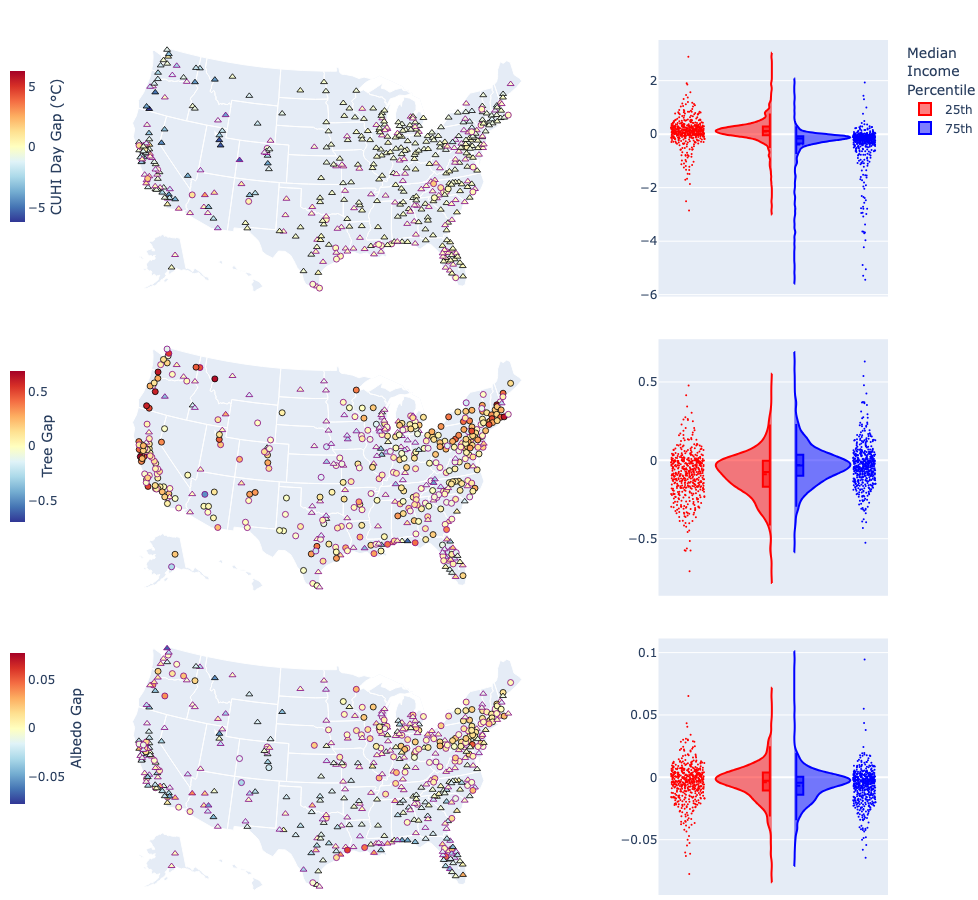

In [34]:
urban_disparity_panel(['CUHI Day (Difference)', 'Tree Fraction (Difference)', 'Albedo (Difference)'], 
                      ['CUHI Day Gap (\u00b0C)', 'Tree Gap', 'Albedo Gap'], 
                      ['CUHI Day', 'Tree Fraction', 'Albedo'], 
                      'uhi_tree_albedo')

### CUHI Night, SUHI Day, and SUHI Night

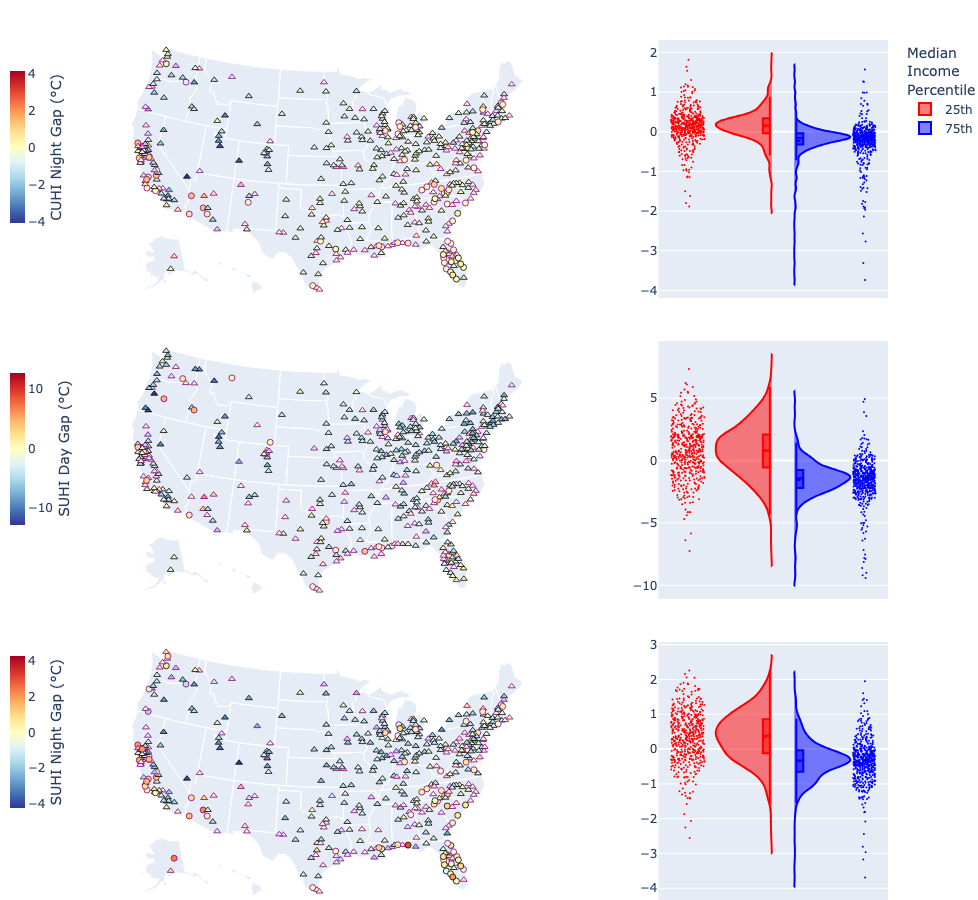

In [35]:
urban_disparity_panel(['CUHI Night (Difference)', 'SUHI Day (Difference)', 'SUHI Night (Difference)'], 
                      ['CUHI Night Gap (\u00b0C)', 'SUHI Day Gap (\u00b0C)', 'SUHI Night Gap (\u00b0C)'], 
                      ['CUHI Night', 'SUHI Day', 'SUHI Night'], 
                      'cuhi_suhi')

### Grass Fraction, Built Fraction, and Elevation

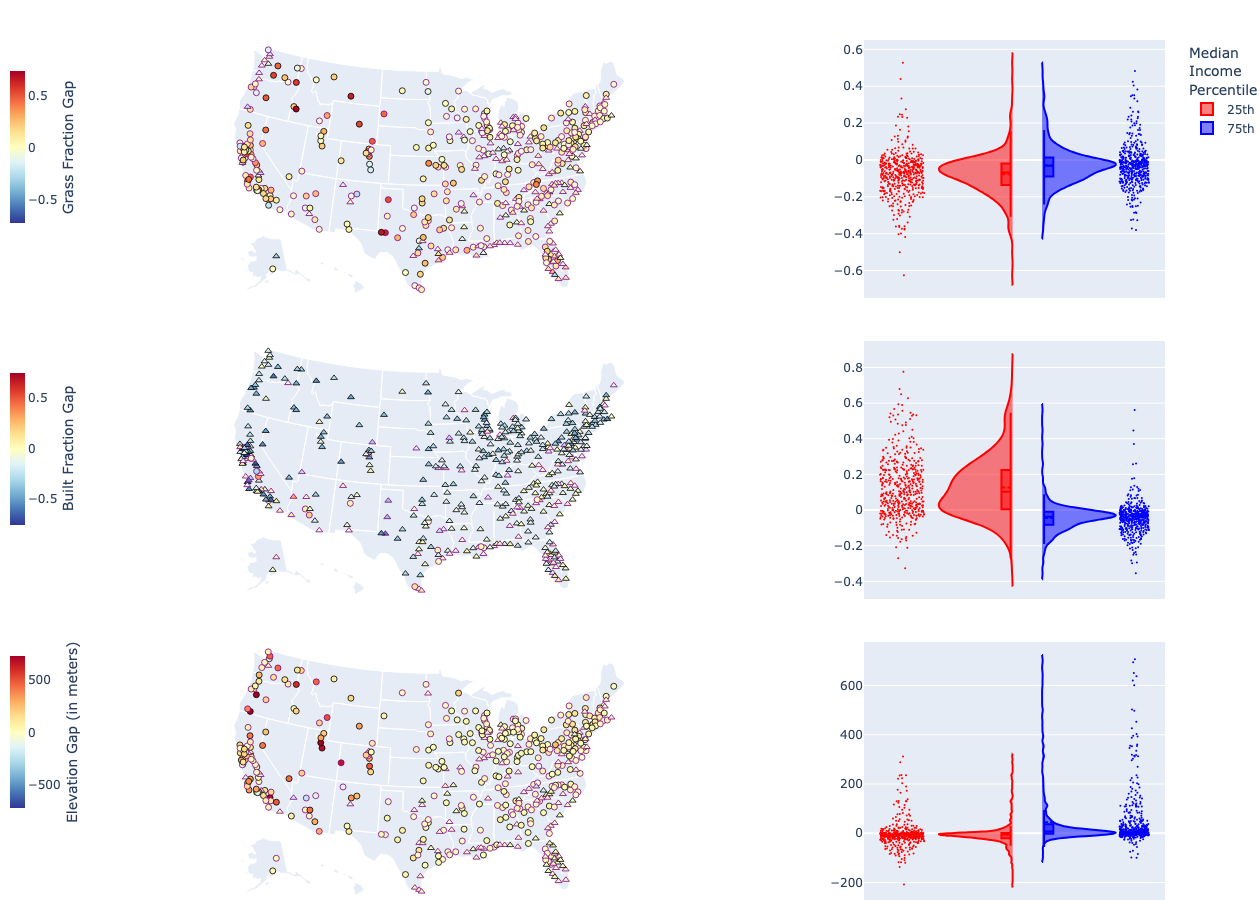

In [36]:
urban_disparity_panel(['Grass Fraction (Difference)', 'Built Fraction (Difference)', 'Elevation (Difference)'], 
                      ['Grass Fraction Gap', 'Built Fraction Gap', 'Elevation Gap (in meters)'], 
                      ['Grass Fraction', 'Built Fraction', 'Elevation'], 
                      'grass_built_elevation')

### Built Albedo, Tree Albedo, and Grass Albedo

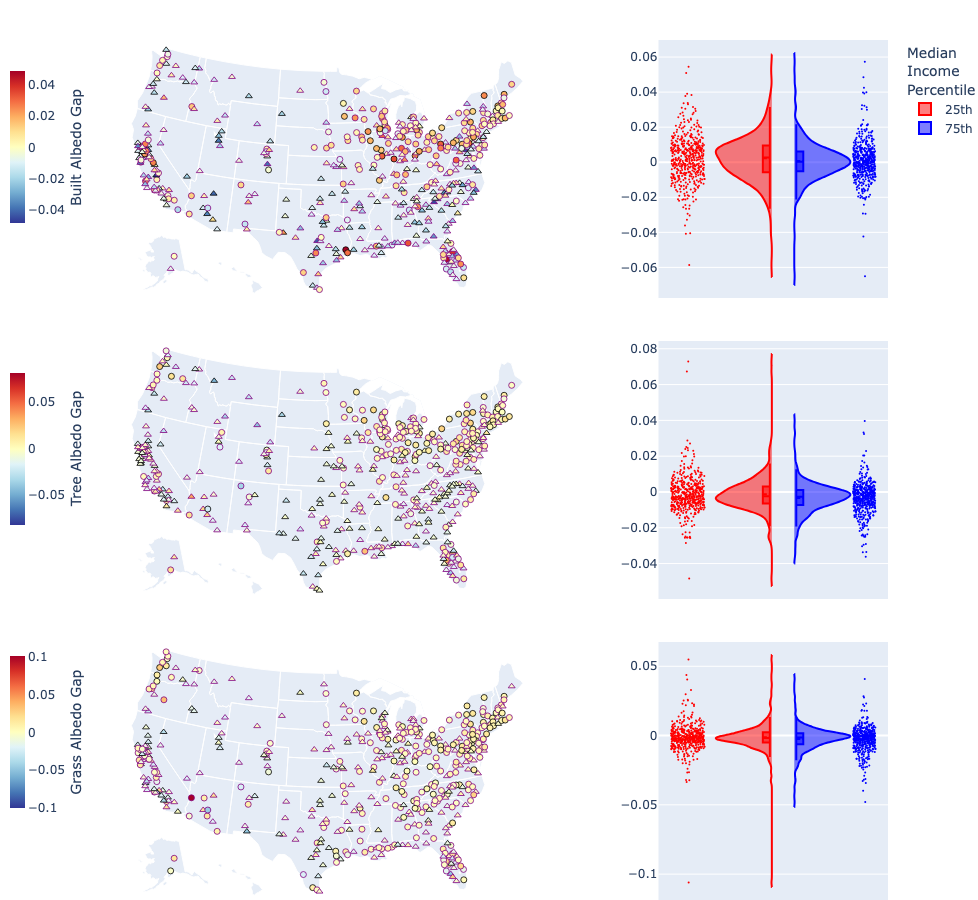

In [37]:
urban_disparity_panel(['Built Albedo (Difference)', 'Tree Albedo (Difference)', 'Grass Albedo (Difference)'], 
                      ['Built Albedo Gap', 'Tree Albedo Gap', ' Grass Albedo Gap'], 
                      ['Built Albedo', 'Tree Albedo', 'Grass Albedo'], 
                      'albedo')

In [267]:
590-15-15

560

## Annotations

In [285]:
def annotate(features, signs, x25_list, y25_list, x75_list, y75_list, svg_path, save_path):
    #x_list = ['325', '715']
    x_list = ['435']
    y_list = [['205', '220', '235', '250', '265', '290'], 
              ['505', '520', '535', '550', '565', '590'], 
              ['805', '820', '835', '850', '865', '890']]
    
    text_list = ['Std: {:.3f}', 'Min: {:.3f}', 'Mean: {:.3f}', 'Median: {:.3f}', 'Max: {:.3f}', '{} cities']
    
    tree = etree.parse(svg_path)
    root = tree.getroot()
    
    text_element = etree.Element('text', x='330', y='20', fill='black', style='font-size: 14px; font-family: Verdana;')
    text_element.text = 'Worse for low income group'
    root.append(text_element)
    
    text_element = etree.Element('text', x='330', y='40', fill='black', style='font-size: 14px; font-family: Verdana;')
    text_element.text = 'Worse for high income group'
    root.append(text_element)
    
    circle = etree.SubElement(root, "circle", cx="318", cy="35", r="5.5")
    root.append(circle)
    
    #triangle = etree.Element("polygon", points="318,5 326,20 310,20")
    triangle = etree.Element("polygon", points="318,10 324,20 312,20")
    #triangle = etree.Element("polygon", points="318,5 324,15 312,15")
    #triangle = etree.Element("polygon", points="318,15 324,30 312,30")
    root.append(triangle)
    
    #triangle = etree.Element("polygon", points="100,10 40,190 160,190")
    #root.append(triangle)
    
    idx=0
    for x in x_list:
        for y in y_list:
            # Annotate Overall Difference
            feature = features[idx]
            sign = signs[idx]
            col = feature + ' (Difference)'
            # Add gap standard deviation annotation
            text_element = etree.Element('text', x=x, y=y[0], fill='black', style='font-size: 12px; font-family: Verdana;')
            text_element.text = text_list[0].format( result[col].std() )
            root.append(text_element)
            
            # Add minimum gap annotation
            text_element = etree.Element('text', x=x, y=y[1], fill='black', style='font-size: 12px; font-family: Verdana;')
            text_element.text = text_list[1].format( result[col].min() )
            root.append(text_element)
            
            # Add mean gap annotation
            text_element = etree.Element('text', x=x, y=y[2], fill='black', style='font-size: 12px; font-family: Verdana;')
            text_element.text = text_list[2].format( result[col].mean() )
            root.append(text_element)
            
            # Add median gap annotation
            text_element = etree.Element('text', x=x, y=y[3], fill='black', style='font-size: 12px; font-family: Verdana;')
            text_element.text = text_list[3].format( result[col].median() )
            root.append(text_element)
            
            # Add maximum gap annotation
            text_element = etree.Element('text', x=x, y=y[4], fill='black', style='font-size: 12px; font-family: Verdana;')
            text_element.text = text_list[4].format( result[col].max() )
            root.append(text_element)
            
            # Add slope annotation
            text_element = etree.Element('text', x=x, y=y[5], fill='black', style='font-size: 12px; font-family: Verdana;')
            slope_col = feature + ' Slope'
            if sign == 'neg':
                text_element.text = text_list[5].format(len(result[result[slope_col] < 0]))
            else:
                text_element.text = text_list[5].format(len(result[result[slope_col] > 0]))
            root.append(text_element)
            
            # Annotate 25th percentile descriptive statistics
            x25 = x25_list[idx]
            y25 = y25_list[idx]
            col25 = feature + ' (25th %tile)'
            text_element = etree.Element('text', x=x25, y=y25[0], fill='red', style='font-size: 12px; font-family: Verdana;')
            text_element.text = 'Std: {:.3f}'.format( result[col25].std() )
            root.append(text_element)
            
            text_element = etree.Element('text', x=x25, y=y25[1], fill='red', style='font-size: 12px; font-family: Verdana;')
            text_element.text = 'Mean: {:.3f}'.format( result[col25].mean() )
            root.append(text_element)
            
            text_element = etree.Element('text', x=x25, y=y25[2], fill='red', style='font-size: 12px; font-family: Verdana;')
            text_element.text = 'Median: {:.3f}'.format( result[col25].median() )
            root.append(text_element)
            
            # Annotate 75th percentile descriptive statistics
            x75 = x75_list[idx]
            y75 = y75_list[idx]
            col75 = feature + ' (75th %tile)'
            text_element = etree.Element('text', x=x75, y=y75[0], fill='blue', style='font-size: 12px; font-family: Verdana;')
            text_element.text = 'Std: {:.3f}'.format( result[col75].std() )
            root.append(text_element)
            
            text_element = etree.Element('text', x=x75, y=y75[1], fill='blue', style='font-size: 12px; font-family: Verdana;')
            text_element.text = 'Mean: {:.3f}'.format( result[col75].mean() )
            root.append(text_element)
            
            text_element = etree.Element('text', x=x75, y=y75[2], fill='blue', style='font-size: 12px; font-family: Verdana;')
            text_element.text = 'Median: {:.3f}'.format( result[col75].median() )
            root.append(text_element)
            
            idx+=1
    
    refs = ['A', 'C', 'E', 'B', 'D', 'F']
    ref_x_loc = ['85', '565']
    ref_y_loc = ['55', '355', '655']
    idx = 0
    for x in ref_x_loc:
        for y in ref_y_loc:
            text_element = etree.Element('text', x=x, y=y, fill='black', style='font-size: 20px; font-family: Verdana;')
            text_element.text = refs[idx]
            root.append(text_element)
            idx+=1
           
    # Save the modified SVG file
    tree.write(save_path, pretty_print=True, xml_declaration=True, encoding='utf-8')

In [289]:
annotate(features=['CUHI Day', 'Tree Fraction', 'Albedo'], 
         signs = ['neg', 'pos', 'neg'],
         x25_list = ['575', '585', '585'],
         y25_list = [['255', '270', '285'], ['340', '355', '370'], ['650', '665', '680']],
         x75_list = ['675', '685', '690'],
         y75_list = [['45', '60', '75'], ['560', '575', '590'], ['650', '665', '680']],
         svg_path='graphs/disparity_panels/uhi_tree_albedo.svg', 
         save_path='graphs/disparity_panels/stats/uhi_tree_albedo.svg')

In [307]:
annotate(features=['CUHI Night', 'SUHI Day', 'SUHI Night'], 
         signs = ['neg', 'neg', 'neg'],
         x25_list = ['575', '580', '580'],
         y25_list = [['250', '265', '280'], ['565', '580', '595'], ['855', '870', '885']],
         x75_list = ['670', '670', '690'],
         y75_list = [['30', '45', '60'], ['350', '365', '380'], ['650', '665', '680']],
         svg_path='graphs/disparity_panels/cuhi_suhi.svg', 
         save_path='graphs/disparity_panels/stats/cuhi_suhi.svg')

In [322]:
annotate(features=['Grass Fraction', 'Built Fraction', 'Elevation'], 
         signs = ['pos', 'neg', 'pos'],
         x25_list = ['565', '580', '580'],
         y25_list = [['265', '280', '295'], ['580', '595', '610'], ['700', '715', '730']],
         x75_list = ['670', '670', '690'],
         y75_list = [['30', '45', '60'], ['350', '365', '380'], ['870', '885', '900']],
         svg_path='graphs/disparity_panels/grass_built_elevation.svg', 
         save_path='graphs/disparity_panels/stats/grass_built_elevation.svg')

In [343]:
annotate(features=['Built Albedo', 'Tree Albedo', 'Grass Albedo'], 
         signs = ['neg', 'neg', 'neg'],
         x25_list = ['565', '565', '565'],
         y25_list = [['265', '280', '295'], ['395', '410', '425'], ['830', '845', '860']],
         x75_list = ['685', '670', '670'],
         y75_list = [['260', '275', '290'], ['350', '365', '380'], ['830', '845', '860']],
         svg_path='graphs/disparity_panels/albedo.svg', 
         save_path='graphs/disparity_panels/stats/albedo.svg')